# This book is identical to ARIMA_soybean_weekly.ipynb, except the addition of section 11 Generate test set predictions

### CONTENTS
### 1 Installations and imports
### 2 Check stationarity assumption
### 3 Visualise ACF and PACF plots for single-differenced series
### 4 Investigate single-differenced non-seasonal model order
### 5 Investigate single-differenced seasonal model order (only relevant for vmd)
### 6 Expand search around most promising seasonal orders
### 7 Check stationarity assumption of seasonal differencing
### 8 Visualise ACF and PACF plots for seasonally-differenced series
### 9 Investigate seasonally-differenced model order
### 10 Generate validation set predictions
### 11 Generate test set predictions

# 1 Installations and imports

In [1]:
# ARIMA installations

!pip install pmdarima
!pip install statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# ARIMA imports

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm #Auto arima
from statsmodels.tsa.stattools import acf #Metrics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [3]:
#General imports

import numpy as np
import pandas as pd

import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib.dates

from datetime import datetime

from google.colab import drive
import json

In [4]:
# Import daily data

data_url = 'https://raw.githubusercontent.com/kumars8/Deloitte_login_prjct/master/soybean_weekly.csv'
soybean_df = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

# fix bad name
soybean_df.columns = ['value']

# take only 1974 - 2017
soybean_df = soybean_df['1974-01-01':'2017-12-31']

# soybean_df needs to lose last value becuase during process of VMD, the last value is lost
soybean_df = soybean_df[:-1]

# view loaded data
soybean_df.tail(2)

,value
date,
2017-12-10,997.8
2017-12-17,974.3


In [5]:
# Import emd data
data_url = 'https://raw.githubusercontent.com/kumars8/Deloitte_login_prjct/master/soybean_emd_weekly.csv'
soybean_emd = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

In [6]:
# Import vmd data
data_url = 'https://raw.githubusercontent.com/kumars8/Deloitte_login_prjct/master/soybean_vmd_weekly.csv'
soybean_vmd = pd.read_csv(data_url, parse_dates=True, dayfirst=True, index_col='date')

In [7]:
# Check indices are aligned
print(soybean_df.index.equals(soybean_emd.index))
print(soybean_df.index.equals(soybean_vmd.index))

True
True


In [8]:
# Split data so that valid and test do not feature in decisions
from sklearn.model_selection import train_test_split

true_train, out_of_sample = train_test_split(soybean_df, test_size=0.2, shuffle=False)
true_valid, true_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)
true_in = true_train.append(true_valid)

emd_train, out_of_sample = train_test_split(soybean_emd, test_size=0.2, shuffle=False)
emd_valid, emd_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)
emd_in = emd_train.append(emd_valid)

vmd_train, out_of_sample = train_test_split(soybean_vmd, test_size=0.2, shuffle=False)
vmd_valid, vmd_test = train_test_split(out_of_sample, test_size=0.5, shuffle=False)
vmd_in = vmd_train.append(vmd_valid)

# 2 Check stationarity assumption: does each series achieve stationarity with a single differencing?

In [9]:
# Non-differenced

In [10]:
# For non-decomposed, non-differenced fails stationarity test
result = adfuller(true_in['value'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.326658
p-value: 0.163514


In [11]:
# EMD non-differenced fails stationarity test
result = adfuller(emd_in['value'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.976726
p-value: 0.296870


In [12]:
# VMD non-differenced fails stationarity test
result = adfuller(vmd_in['value'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.295899
p-value: 0.173294


In [13]:
# Differenced

In [14]:
# ADF non-decomposed differenced passes stationarity test
result = adfuller(true_in['value'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -14.097861
p-value: 0.000000


In [15]:
# ADF EMD differenced passes stationarity test
result = adfuller(emd_in['value'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.967785
p-value: 0.000000


In [16]:
# ADF VMD differenced passes stationarity test
result = adfuller(vmd_in['value'].diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7.882916
p-value: 0.000000


# 3 Visualise ACF and PACF plots for single-differenced series

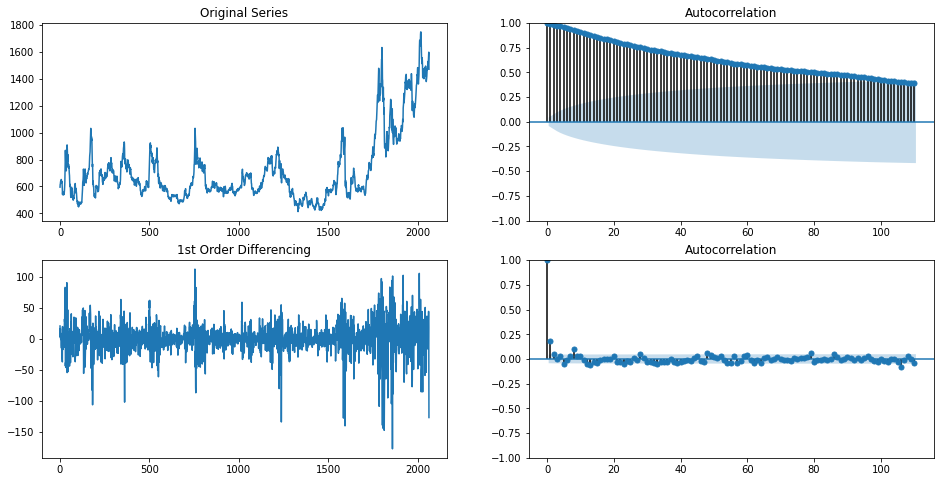

In [17]:
# ACF no decomp, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(true_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = true_in['value'].values
lags_n = 110
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(true_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = true_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

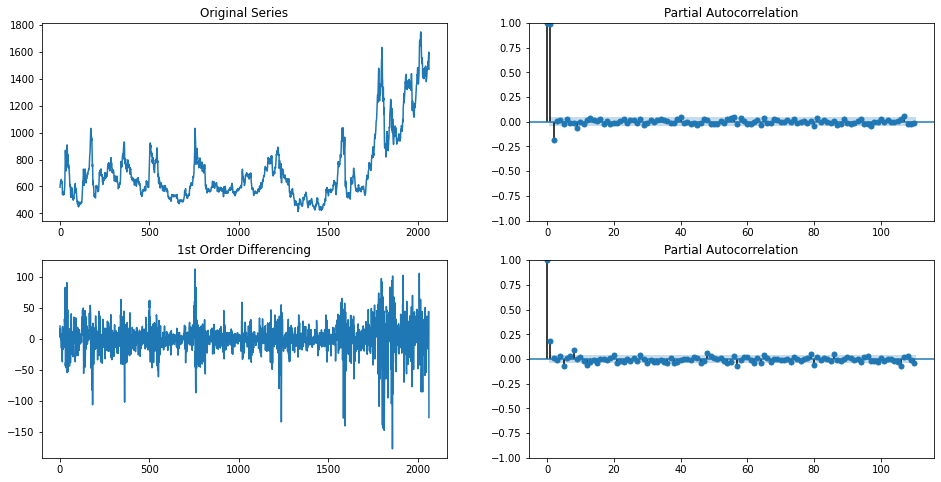

In [18]:
# PACF no decomp, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(true_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = true_in['value'].values
lags_n = 110
plot_pacf(series_data, ax=axes[0, 1], lags=lags_n, method='ywm')

# 1st Differencing
axes[1, 0].plot(true_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = true_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_pacf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n, method='ywm')

plt.show()

In [19]:
# Looks like p=1, q=1 at most
# ARIMA doesn't seem suitable for this series - non-decomposed investigations stop here

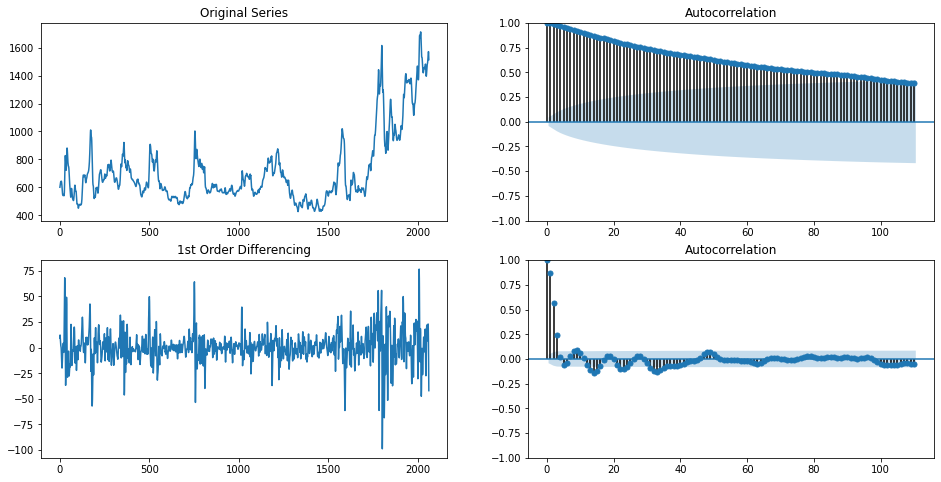

In [20]:
# ACF emd, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(emd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = emd_in['value'].values
lags_n = 110
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(emd_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = emd_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

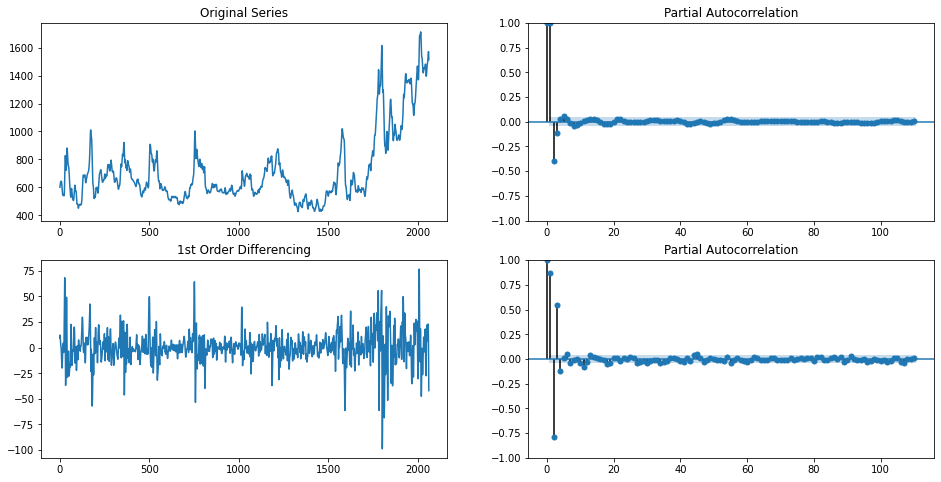

In [21]:
# PACF emd, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(emd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = emd_in['value'].values
lags_n = 110
plot_pacf(series_data, ax=axes[0, 1], lags=lags_n, method='ywm')

# 1st Differencing
axes[1, 0].plot(emd_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = emd_in['value'].diff().dropna().values
first_diff_lags_n = 110
plot_pacf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n, method='ywm')

plt.show()

In [22]:
# Differenced ACF/PACF suggests could be as many as 3 autoregressive terms and 3 moving average terms

# Non-differenced PACF suggests maybe lag 4 differencing

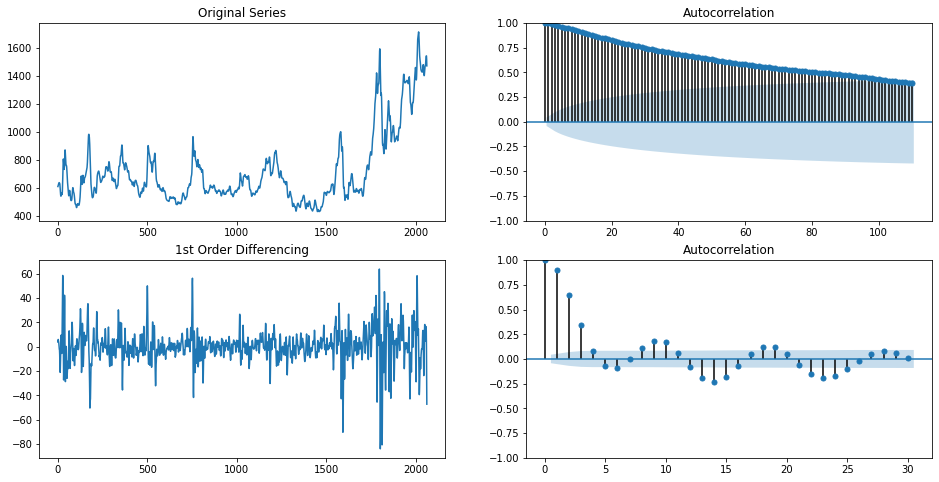

In [23]:
# ACF vmd, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(vmd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = vmd_in['value'].values
lags_n = 110
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(vmd_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = vmd_in['value'].diff().dropna().values
first_diff_lags_n = 30
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

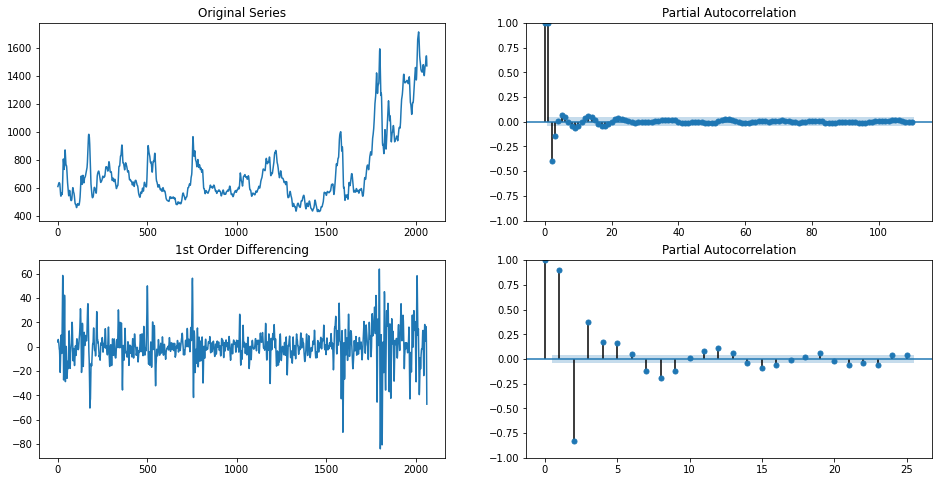

In [24]:
# PACF vmd, 1 diff

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(vmd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = vmd_in['value'].values
lags_n = 110
plot_pacf(series_data, ax=axes[0, 1], lags=lags_n, method='ywm')

# 1st Differencing
axes[1, 0].plot(vmd_in['value'].diff().values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = vmd_in['value'].diff().dropna().values
first_diff_lags_n = 25
plot_pacf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n, method='ywm')

plt.show()

In [25]:
# Differenced ACF/PACF suggests p is as many as 3, q is as many as 2

# differenced ACF suggests trying seasonal with lag 8, 9, 10
# differenced PACF suggest trying seasonal with lag 4, 5, 6

# 4 Investigate single-differenced non-seasonal model order

In [26]:
# auto arima emd
emd_arima = pm.auto_arima(emd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=6)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16996.541, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14049.568, Time=0.50 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14391.730, Time=1.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16996.366, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11834.139, Time=0.69 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=10649.084, Time=1.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=10189.290, Time=2.31 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=10500.597, Time=1.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=10174.370, Time=3.33 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=10215.107, Time=2.02 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10174.665, Time=4.12 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10179.838, Time=3.21 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=10172.652, Time=1.01 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=10213.534, Time=0.70 sec
 ARIMA(3,1,1)(0,0,0

In [27]:
# auto arima vmd
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=1,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=5)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=16622.715, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13191.621, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14041.985, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=16622.672, Time=0.09 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=10363.583, Time=0.64 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=9430.118, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=9431.928, Time=2.22 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9608.251, Time=1.39 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=9428.327, Time=0.53 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=10362.643, Time=0.48 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=9430.147, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=9606.912, Time=0.58 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 9.819 seconds


# 5 Investigate single-differenced seasonal model order (only relevant for vmd)

In [28]:
# try vmd seasonal models with autoregressive lags 4,5,6 and moving average lags 8,9,10

In [29]:
# auto arima vmd, lag 4
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=4,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=1, max_P=3,
                      start_Q=0, max_Q=0,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=7)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,0)[4] intercept   : AIC=16612.809, Time=1.24 sec
 ARIMA(0,1,0)(0,0,0)[4] intercept   : AIC=16622.715, Time=0.12 sec
 ARIMA(1,1,0)(1,0,0)[4] intercept   : AIC=12430.363, Time=1.66 sec
 ARIMA(0,1,1)(0,0,0)[4] intercept   : AIC=14041.985, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[4]             : AIC=16622.672, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[4] intercept   : AIC=13191.621, Time=0.31 sec
 ARIMA(1,1,0)(2,0,0)[4] intercept   : AIC=12394.549, Time=2.33 sec
 ARIMA(1,1,0)(3,0,0)[4] intercept   : AIC=12375.603, Time=3.48 sec
 ARIMA(0,1,0)(3,0,0)[4] intercept   : AIC=16571.674, Time=2.79 sec
 ARIMA(2,1,0)(3,0,0)[4] intercept   : AIC=10073.787, Time=4.18 sec
 ARIMA(2,1,0)(2,0,0)[4] intercept   : AIC=10076.254, Time=4.46 sec
 ARIMA(3,1,0)(3,0,0)[4] intercept   : AIC=9368.183, Time=3.20 sec
 ARIMA(3,1,0)(2,0,0)[4] intercept   : AIC=9389.587, Time=2.52 sec
 ARIMA(3,1,1)(3,0,0)[4] intercept   : AIC=9360.869, Time=6.09 sec
 ARIMA(3,1,1)(2,0,0)[4

In [30]:
# auto arima vmd, lag 5
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=5,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=1, max_P=2,
                      start_Q=0, max_Q=0,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=7)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,0)[5] intercept   : AIC=16613.109, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=16622.715, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=11938.370, Time=1.18 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=14041.985, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=16622.672, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=13191.621, Time=0.16 sec
 ARIMA(1,1,0)(2,0,0)[5] intercept   : AIC=11932.594, Time=2.36 sec
 ARIMA(0,1,0)(2,0,0)[5] intercept   : AIC=16559.637, Time=1.81 sec
 ARIMA(2,1,0)(2,0,0)[5] intercept   : AIC=9911.393, Time=2.18 sec
 ARIMA(2,1,0)(1,0,0)[5] intercept   : AIC=10070.365, Time=1.33 sec
 ARIMA(3,1,0)(2,0,0)[5] intercept   : AIC=9415.736, Time=2.40 sec
 ARIMA(3,1,0)(1,0,0)[5] intercept   : AIC=9422.520, Time=1.27 sec
 ARIMA(3,1,1)(2,0,0)[5] intercept   : AIC=9400.726, Time=4.17 sec
 ARIMA(3,1,1)(1,0,0)[5] intercept   : AIC=9421.596, Time=3.17 sec
 ARIMA(2,1,1)(2,0,0)[5] 

In [31]:
# auto arima vmd, lag 6
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=6,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=1, max_P=1,
                      start_Q=0, max_Q=0,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=6)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,0)[6] intercept   : AIC=16607.964, Time=0.58 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=16622.715, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=12580.407, Time=1.17 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=14041.985, Time=0.63 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=16622.672, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=13191.621, Time=0.16 sec
 ARIMA(2,1,0)(1,0,0)[6] intercept   : AIC=10334.264, Time=1.10 sec
 ARIMA(2,1,0)(0,0,0)[6] intercept   : AIC=10363.583, Time=0.41 sec
 ARIMA(3,1,0)(1,0,0)[6] intercept   : AIC=9404.907, Time=1.45 sec
 ARIMA(3,1,0)(0,0,0)[6] intercept   : AIC=9430.118, Time=0.49 sec
 ARIMA(3,1,1)(1,0,0)[6] intercept   : AIC=9406.393, Time=2.52 sec
 ARIMA(2,1,1)(1,0,0)[6] intercept   : AIC=9603.258, Time=1.48 sec
 ARIMA(3,1,0)(1,0,0)[6]             : AIC=9403.116, Time=0.56 sec
 ARIMA(3,1,0)(0,0,0)[6]             : AIC=9428.327, Time=0.22 sec
 ARIMA(2,1,0)(1,0,0)[6]  

In [32]:
# auto arima vmd, lag 8
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=8,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=0, max_P=0,
                      start_Q=1, max_Q=3,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=7)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[8] intercept   : AIC=16593.501, Time=0.86 sec
 ARIMA(0,1,0)(0,0,0)[8] intercept   : AIC=16622.715, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[8] intercept   : AIC=13191.621, Time=0.16 sec
 ARIMA(0,1,1)(0,0,1)[8] intercept   : AIC=13996.096, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[8]             : AIC=16622.672, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[8] intercept   : AIC=13082.228, Time=1.23 sec
 ARIMA(1,1,0)(0,0,2)[8] intercept   : AIC=13074.025, Time=2.95 sec
 ARIMA(1,1,0)(0,0,3)[8] intercept   : AIC=12996.913, Time=6.38 sec
 ARIMA(0,1,0)(0,0,3)[8] intercept   : AIC=16532.717, Time=7.05 sec
 ARIMA(2,1,0)(0,0,3)[8] intercept   : AIC=10072.967, Time=7.62 sec
 ARIMA(2,1,0)(0,0,2)[8] intercept   : AIC=10076.791, Time=2.89 sec
 ARIMA(3,1,0)(0,0,3)[8] intercept   : AIC=9424.407, Time=6.65 sec
 ARIMA(3,1,0)(0,0,2)[8] intercept   : AIC=9422.595, Time=3.23 sec
 ARIMA(3,1,0)(0,0,1)[8] intercept   : AIC=9421.170, Time=1.50 sec
 ARIMA(3,1,0)(0,0,0)[8

In [33]:
# auto arima vmd, lag 9
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=9,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=0, max_P=0,
                      start_Q=1, max_Q=2,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=7)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[9] intercept   : AIC=16563.734, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[9] intercept   : AIC=16622.715, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[9] intercept   : AIC=13191.621, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[9] intercept   : AIC=13996.034, Time=1.78 sec
 ARIMA(0,1,0)(0,0,0)[9]             : AIC=16622.672, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[9] intercept   : AIC=12900.542, Time=1.49 sec
 ARIMA(1,1,0)(0,0,2)[9] intercept   : AIC=12703.923, Time=3.13 sec
 ARIMA(0,1,0)(0,0,2)[9] intercept   : AIC=16538.592, Time=2.16 sec
 ARIMA(2,1,0)(0,0,2)[9] intercept   : AIC=9943.712, Time=3.38 sec
 ARIMA(2,1,0)(0,0,1)[9] intercept   : AIC=10037.050, Time=1.74 sec
 ARIMA(3,1,0)(0,0,2)[9] intercept   : AIC=9428.736, Time=3.87 sec
 ARIMA(3,1,0)(0,0,1)[9] intercept   : AIC=9430.547, Time=1.99 sec
 ARIMA(3,1,1)(0,0,2)[9] intercept   : AIC=9425.869, Time=6.70 sec
 ARIMA(3,1,1)(0,0,1)[9] intercept   : AIC=9431.013, Time=2.97 sec
 ARIMA(2,1,1)(0,0,2)[9] 

In [34]:
# auto arima vmd, lag 10
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=10,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=0, max_P=0,
                      start_Q=1, max_Q=1,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=6)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[10] intercept   : AIC=16569.674, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=16622.715, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[10] intercept   : AIC=13191.621, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=13965.528, Time=2.27 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=16622.672, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[10] intercept   : AIC=12840.088, Time=1.69 sec
 ARIMA(2,1,0)(0,0,1)[10] intercept   : AIC=10090.984, Time=1.64 sec
 ARIMA(2,1,0)(0,0,0)[10] intercept   : AIC=10363.583, Time=0.43 sec
 ARIMA(3,1,0)(0,0,1)[10] intercept   : AIC=9426.522, Time=1.68 sec
 ARIMA(3,1,0)(0,0,0)[10] intercept   : AIC=9430.118, Time=0.49 sec
 ARIMA(3,1,1)(0,0,1)[10] intercept   : AIC=9425.418, Time=3.26 sec
 ARIMA(3,1,1)(0,0,0)[10] intercept   : AIC=9431.928, Time=1.25 sec
 ARIMA(2,1,1)(0,0,1)[10] intercept   : AIC=9518.606, Time=2.05 sec
 ARIMA(3,1,2)(0,0,1)[10] intercept   : AIC=9382.780, Time=6.52 sec
 ARIMA(3,1,

In [36]:
# best vmd models with seasonal components to this point:

# seasonal moving average
(3,1,2)(0,0,1)[10]  AIC:6067
(3,1,2)(0,0,3)[8]   AIC:6072

# seasonal autoregressive
(3,1,2)(2,0,0)[5]   AIC:6060

SyntaxError: ignored

# 6 Expand search around most promising seasonal orders

In [37]:
# auto arima vmd, lag 10
vmd_arima = pm.auto_arima(vmd_in, start_p=2, start_q=1,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=10,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=8)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[10] intercept   : AIC=9608.251, Time=0.80 sec
 ARIMA(0,1,0)(0,0,0)[10] intercept   : AIC=16622.715, Time=0.09 sec
 ARIMA(1,1,0)(1,0,0)[10] intercept   : AIC=12780.019, Time=1.36 sec
 ARIMA(0,1,1)(0,0,1)[10] intercept   : AIC=13965.528, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[10]             : AIC=16622.672, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[10] intercept   : AIC=9509.323, Time=2.15 sec
 ARIMA(2,1,1)(2,0,0)[10] intercept   : AIC=9511.319, Time=5.97 sec
 ARIMA(2,1,1)(1,0,1)[10] intercept   : AIC=9511.321, Time=3.42 sec
 ARIMA(2,1,1)(0,0,1)[10] intercept   : AIC=9518.606, Time=2.04 sec
 ARIMA(2,1,1)(2,0,1)[10] intercept   : AIC=9511.318, Time=13.18 sec
 ARIMA(1,1,1)(1,0,0)[10] intercept   : AIC=10805.317, Time=1.67 sec
 ARIMA(2,1,0)(1,0,0)[10] intercept   : AIC=10072.225, Time=1.63 sec
 ARIMA(3,1,1)(1,0,0)[10] intercept   : AIC=9424.162, Time=3.06 sec
 ARIMA(3,1,1)(0,0,0)[10] intercept   : AIC=9431.928, Time=1.27 sec
 ARIMA(3,1,1

In [38]:
# auto arima vmd, lag 8
vmd_arima = pm.auto_arima(vmd_in, start_p=2, start_q=1,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=8,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=3,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=8)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[8] intercept   : AIC=9608.251, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[8] intercept   : AIC=16622.715, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[8] intercept   : AIC=13086.607, Time=1.30 sec
 ARIMA(0,1,1)(0,0,1)[8] intercept   : AIC=13996.096, Time=1.93 sec
 ARIMA(0,1,0)(0,0,0)[8]             : AIC=16622.672, Time=0.07 sec
 ARIMA(2,1,1)(1,0,0)[8] intercept   : AIC=9502.530, Time=1.87 sec
 ARIMA(2,1,1)(2,0,0)[8] intercept   : AIC=9499.525, Time=4.70 sec
 ARIMA(2,1,1)(2,0,1)[8] intercept   : AIC=9491.482, Time=7.36 sec
 ARIMA(2,1,1)(1,0,1)[8] intercept   : AIC=9501.144, Time=3.25 sec
 ARIMA(2,1,1)(2,0,2)[8] intercept   : AIC=9488.535, Time=10.88 sec
 ARIMA(2,1,1)(1,0,2)[8] intercept   : AIC=9501.910, Time=8.59 sec
 ARIMA(2,1,1)(2,0,3)[8] intercept   : AIC=9481.598, Time=32.02 sec
 ARIMA(2,1,1)(1,0,3)[8] intercept   : AIC=9493.957, Time=17.12 sec
 ARIMA(1,1,1)(2,0,3)[8] intercept   : AIC=10955.482, Time=26.01 sec
 ARIMA(2,1,0)(2,0,3)[8] 

In [39]:
# auto arima vmd, lag 5
vmd_arima = pm.auto_arima(vmd_in, start_p=2, start_q=1,
                      test='adf',
                      max_p=3, max_q=2, # maximum p and q
                      m=5,              # frequency of series
                      d=1,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=0, max_P=3,
                      start_Q=0, max_Q=2,
                      D=0,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=8)

Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=9608.251, Time=0.77 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=16622.715, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=11938.370, Time=1.19 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=14015.918, Time=1.53 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=16622.672, Time=0.06 sec
 ARIMA(2,1,1)(1,0,0)[5] intercept   : AIC=9513.073, Time=1.54 sec
 ARIMA(2,1,1)(2,0,0)[5] intercept   : AIC=9426.955, Time=2.79 sec
 ARIMA(2,1,1)(3,0,0)[5] intercept   : AIC=9424.372, Time=4.13 sec
 ARIMA(2,1,1)(3,0,1)[5] intercept   : AIC=9423.664, Time=10.62 sec
 ARIMA(2,1,1)(2,0,1)[5] intercept   : AIC=9425.709, Time=3.53 sec
 ARIMA(2,1,1)(3,0,2)[5] intercept   : AIC=9417.244, Time=17.33 sec
 ARIMA(2,1,1)(2,0,2)[5] intercept   : AIC=9415.519, Time=6.76 sec
 ARIMA(2,1,1)(1,0,2)[5] intercept   : AIC=9421.417, Time=4.08 sec
 ARIMA(2,1,1)(1,0,1)[5] intercept   : AIC=9440.850, Time=2.40 sec
 ARIMA(1,1,1)(2,0,2)[5] int

# 7 Check stationarity assumption of seasonal differencing

In [40]:
# Due to the pattern in non-differenced emd and vmd PACFs, checks are necessary on stationarity, ACF and PACF after seasonal differencing
# Try emd seasonal differencing @ lag 4, and vmd seasonal differencing @ lag 5

In [41]:
# EMD differenced at lag 4 passes stationarity test
result = adfuller(emd_in['value'].diff(4).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -9.529761
p-value: 0.000000


In [42]:
# VMD differenced at lag 5 passes stationarity test
result = adfuller(vmd_in['value'].diff(5).dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -10.023447
p-value: 0.000000


# 8 Visualise ACF and PACF plots for seasonally-differenced series

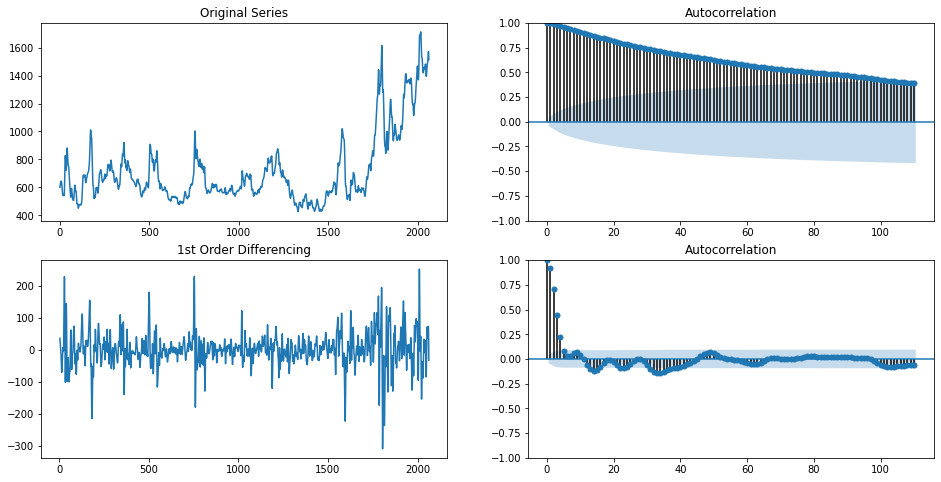

In [43]:
# ACF emd, 1 diff at lag 4

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(emd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = emd_in['value'].values
lags_n = 110
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(emd_in['value'].diff(4).values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = emd_in['value'].diff(4).dropna().values
first_diff_lags_n = 110
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

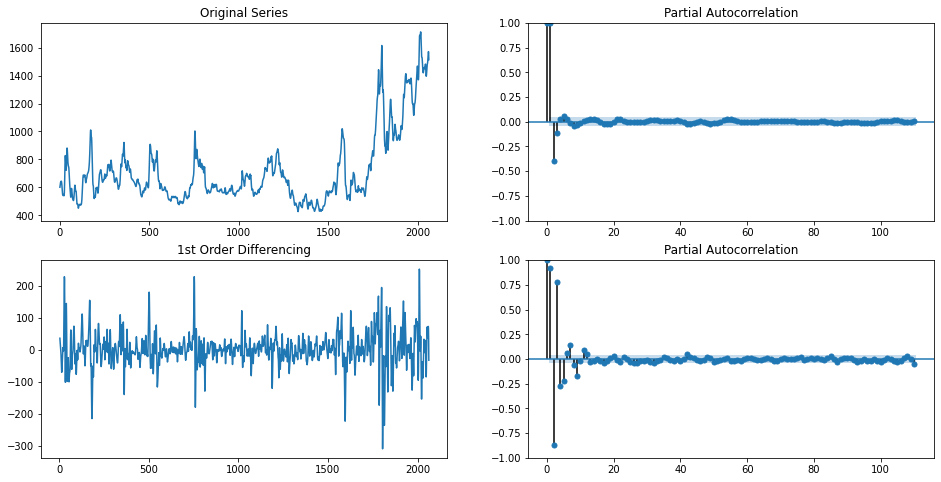

In [44]:
# PACF emd, 1 diff at lag 4

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(emd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = emd_in['value'].values
lags_n = 110
plot_pacf(series_data, ax=axes[0, 1], lags=lags_n, method='ywm')

# 1st Differencing
axes[1, 0].plot(emd_in['value'].diff(4).values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = emd_in['value'].diff(4).dropna().values
first_diff_lags_n = 110
plot_pacf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n, method='ywm')

plt.show()

In [45]:
# 3, 3 shows promise in this case

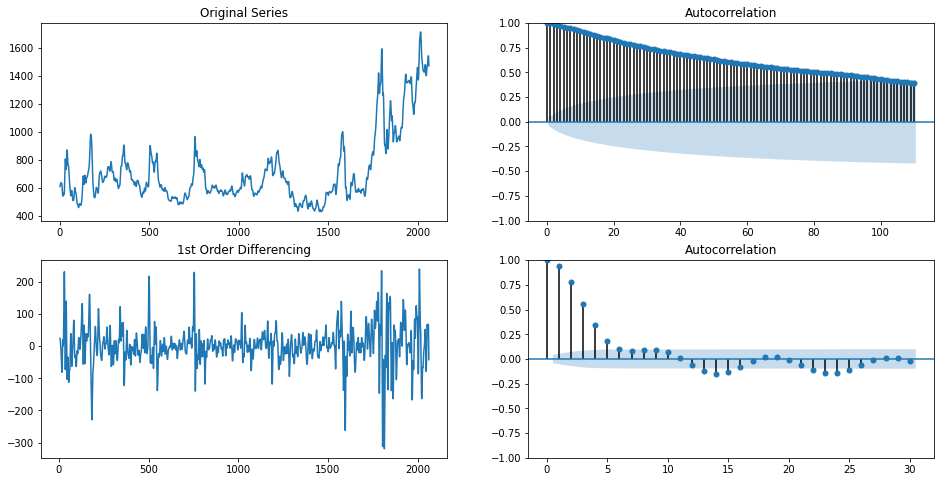

In [46]:
# ACF vmd, 1 diff at lag 5

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(vmd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = vmd_in['value'].values
lags_n = 110
plot_acf(series_data, ax=axes[0, 1], lags=lags_n)

# 1st Differencing
axes[1, 0].plot(vmd_in['value'].diff(5).values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = vmd_in['value'].diff(5).dropna().values
first_diff_lags_n = 30
plot_acf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n)

plt.show()

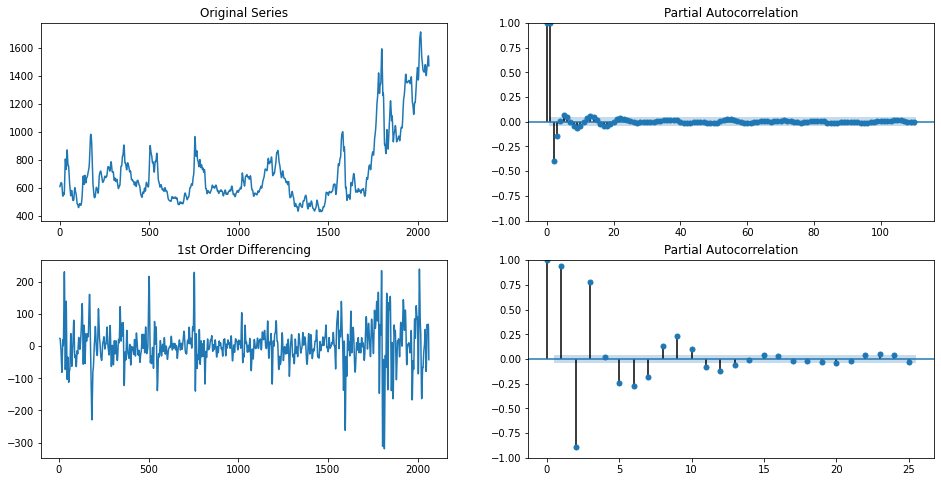

In [47]:
# PACF vmd, 1 diff at lag 5

plt.rcParams.update({'figure.figsize':(16,8)})

# Original Series
fig, axes = plt.subplots(2, 2)#, sharex=True)
axes[0, 0].plot(vmd_in['value'].dropna().values)
axes[0, 0].set_title('Original Series')
series_data = vmd_in['value'].values
lags_n = 110
plot_pacf(series_data, ax=axes[0, 1], lags=lags_n, method='ywm')

# 1st Differencing
axes[1, 0].plot(vmd_in['value'].diff(5).values)
axes[1, 0].set_title('1st Order Differencing')
first_diff_series = vmd_in['value'].diff(5).dropna().values
first_diff_lags_n = 25
plot_pacf(first_diff_series, ax=axes[1, 1], lags=first_diff_lags_n, method='ywm')

plt.show()

In [48]:
# Anything up to 4, 4 may work well

# 9 Investigate seasonally-differenced model order

In [49]:
# auto arima emd, seasonal difference lag 4
emd_arima = pm.auto_arima(emd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=3, max_q=3, # maximum p and q
                      m=4,              # frequency of series
                      d=0,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=0, max_P=1,
                      start_Q=0, max_Q=3,
                      D=1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=7)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[4] intercept   : AIC=22085.335, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[4] intercept   : AIC=17640.713, Time=1.93 sec
 ARIMA(0,0,1)(0,1,1)[4] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(0,0,0)(0,1,0)[4]             : AIC=22085.896, Time=0.07 sec
 ARIMA(1,0,0)(0,1,0)[4] intercept   : AIC=18268.193, Time=0.19 sec
 ARIMA(1,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=5.81 sec
 ARIMA(1,0,0)(0,1,1)[4] intercept   : AIC=inf, Time=2.68 sec
 ARIMA(0,0,0)(1,1,0)[4] intercept   : AIC=21986.584, Time=1.18 sec
 ARIMA(2,0,0)(1,1,0)[4] intercept   : AIC=14183.659, Time=2.13 sec
 ARIMA(2,0,0)(0,1,0)[4] intercept   : AIC=15281.953, Time=0.65 sec
 ARIMA(2,0,0)(1,1,1)[4] intercept   : AIC=inf, Time=5.05 sec
 ARIMA(2,0,0)(0,1,1)[4] intercept   : AIC=inf, Time=3.71 sec
 ARIMA(3,0,0)(1,1,0)[4] intercept   : AIC=12362.809, Time=2.47 sec
 ARIMA(3,0,0)(0,1,0)[4] intercept   : AIC=12646.106, Time=0.83 sec
 ARIMA(3,0,0)(1,1,1)[4] intercept   : AIC=inf, Ti

In [50]:
# auto arima vmd, seasonal difference lag 5
vmd_arima = pm.auto_arima(vmd_in, start_p=0, start_q=0,
                      test='adf',
                      max_p=4, max_q=4, # maximum p and q
                      m=5,              # frequency of series
                      d=0,              # stationarity is achieved with one differencing
                      seasonal=True,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      D=1,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      max_order=8)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=22489.700, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=17179.569, Time=1.89 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=22490.758, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=18101.924, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[5] intercept   : AIC=17133.934, Time=4.12 sec
 ARIMA(1,0,0)(2,1,1)[5] intercept   : AIC=inf, Time=7.40 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=5.88 sec
 ARIMA(0,0,0)(2,1,0)[5] intercept   : AIC=22419.822, Time=3.21 sec
 ARIMA(2,0,0)(2,1,0)[5] intercept   : AIC=12144.965, Time=5.24 sec
 ARIMA(2,0,0)(1,1,0)[5] intercept   : AIC=12571.354, Time=2.26 sec
 ARIMA(2,0,0)(2,1,1)[5] intercept   : AIC=11856.977, Time=13.47 sec
 ARIMA(2,0,0)(1,1,1)[5] intercept   : AIC=11868.843, Time=6.11 sec
 ARIMA(2,0,0)(2,1,2)[5] intercept   : AIC=11851.972, Time=13.99 sec
 ARIMA(2,0,0)(1,1,2)[5] intercept  

In [51]:
# Best models found to this point:

#emd (3,0,0)(1,1,0)[4]
#vmd (2,0,0)(2,1,2)[5]

# 10 Generate validation set predictions, for use in forecast combination step

In [52]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [53]:
predictions_rolling = []

for i in range(len(emd_valid)):

  train_set = pd.concat([emd_train, emd_valid[:i]]) #concatenating here is quite inefficient, and avoidable

  emd_arima_model = ARIMA(train_set['value'].dropna().values, order=(3, 0, 0),seasonal_order=(1, 1, 0, 4), enforce_stationarity=False)  
  emd_arima_fit = emd_arima_model.fit()

  fc = emd_arima_fit.forecast()
  predictions_rolling.append(fc[0])

with open(f'/content/gdrive/MyDrive/outputs/test/emd_ARIMA_weekly_valid.json', 'w') as fp:
  json.dump(predictions_rolling, fp)

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [54]:
predictions_rolling = []

for i in range(len(vmd_valid)):

  train_set = pd.concat([vmd_train, vmd_valid[:i]]) #concatenating here is quite inefficient, and avoidable

  vmd_arima_model = ARIMA(train_set['value'].dropna().values, order=(2, 0, 0), seasonal_order=(2, 1, 2, 5), enforce_stationarity=False)  
  vmd_arima_fit = vmd_arima_model.fit()

  fc = vmd_arima_fit.forecast()
  predictions_rolling.append(fc[0])

with open(f'/content/gdrive/MyDrive/outputs/test/vmd_ARIMA_weekly_valid.json', 'w') as fp:
  json.dump(predictions_rolling, fp)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packa

# 11 Generate test set predictions

In [55]:
predictions_rolling = []

for i in range(len(emd_test)):

  train_set = pd.concat([emd_in, emd_test[:i]]) #concatenating here is quite inefficient, and avoidable

  emd_arima_model = ARIMA(train_set['value'].dropna().values, order=(3, 0, 0),seasonal_order=(1, 1, 0, 4), enforce_stationarity=False)  
  emd_arima_fit = emd_arima_model.fit()

  fc = emd_arima_fit.forecast()
  predictions_rolling.append(fc[0])

with open(f'/content/gdrive/MyDrive/outputs/test/emd_ARIMA_weekly_test.json', 'w') as fp:
  json.dump(predictions_rolling, fp)

In [57]:
predictions_rolling = []

for i in range(len(vmd_test)):

  train_set = pd.concat([vmd_in, vmd_test[:i]]) #concatenating here is quite inefficient, and avoidable

  vmd_arima_model = ARIMA(train_set['value'].dropna().values,  order=(2, 0, 0), seasonal_order=(2, 1, 2, 5), enforce_stationarity=False)  
  vmd_arima_fit = vmd_arima_model.fit()

  fc = vmd_arima_fit.forecast()
  predictions_rolling.append(fc[0])

with open(f'/content/gdrive/MyDrive/outputs/test/vmd_ARIMA_weekly_test.json', 'w') as fp:
  json.dump(predictions_rolling, fp)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packa

# End